In [233]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List
import matplotlib.pyplot as plt
from math import floor,ceil
%matplotlib inline

dataset = pd.read_csv('data/synchronized-eeg.csv',
                      parse_dates=['indra_time'],
                      index_col='indra_time')
# # convert to arrays from strings
dataset.raw_values = dataset.raw_values.map(json.loads)


Populating the interactive namespace from numpy and matplotlib


/Users/suchismitapadhy/anaconda3/envs/MRenv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['floor', 'ceil']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [234]:
len(dataset.raw_values)

30013

# 1. EEG

Neurons produce electrical activity in the brain.

If we zoom out far enough (and, for our purposes, we must), these neuronal firings appear most clearly as patterns of constructive or destructive interference. They are typically low-frequency waves, 0.5Hz-70Hz.

But, don't take my word for it. Let's open up a signal from our corpus.

Here's 512 readings, or one second, of the 30,000 seconds in our dataset. Let's take the 100th reading in our dataset:

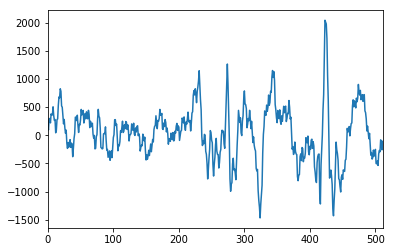

In [235]:
pd.Series(dataset.raw_values[100].values).plot()

This is *time-domain* data. It represents voltages over time.

We can turn this into *frequency-domain* data using an [FFT](https://www.youtube.com/watch?v=iWZNTM139xQ). (You don't need to understand how this works right now). We'll produce what's called a *power spectrum*.


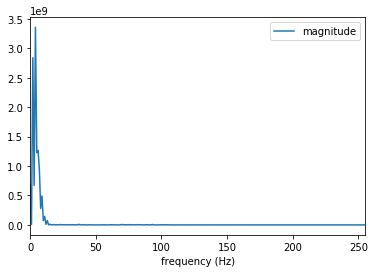

In [236]:
def to_power_spectrum (
    raw_readings: np.array,
    sampling_rate: int = 512,
) -> pd.Series:
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    '''
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum

ps = to_power_spectrum(dataset.raw_values[1000])
ps.plot(x='frequency (Hz)')

Now, we can see some low-frequency data, toward the left side of the graph

Let's do a "band-pass" between 0.5Hz and 20Hz, effectively "zooming in" or "cropping" to these frequencies.

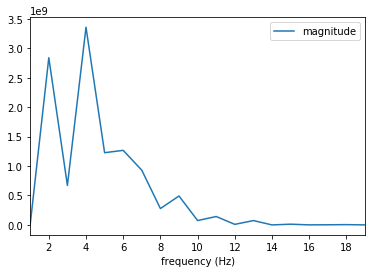

In [237]:
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,
) -> pd.Series:
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]

bandpass(ps, 0.5, 20).plot(x='frequency (Hz)')

Now, here's the problem: There's a bunch of other crap in the signal, too!

For example, along with the EEG signal we just saw, there's also a bunch of EMG (electromyographic) data, which is produced by the muscles in your face, or from moving your eyes!

Most of this signal will be in the *50Hz to 150Hz* range. Eyeblinks will cause big spikes in this frequency band.

### TODO
Bandpass to the EMG frequency bands, and plot them. If you want, see if you can find any readings with big spikes in this band!

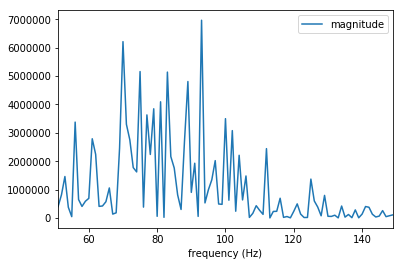

In [238]:
# your code here
bandpass(ps, 50, 150).plot(x='frequency (Hz)')

We might also see ECG (electrocardiographic) signals, from the heart.

We'll even see background radiation from the electrical system! Here in North America, we'll see a 60Hz spike no matter what we do.

# 2. Classification

We can go crazy trying to filter all of these artifacts (and many have). 

However, we are at Berkeley, so we will take a lazy (computational) view.

We will shift our perspective in two ways, and in the end, we will not feel obligated to filter artifacts:

1. *The electromagnet is a general-purpose **biosensor***. We are sensing a multitude of human activity, including, but not limited to, EEG.

2. *Our machine learning will handle the artifacts*. If some artifacts really are artifacts (i.e., they are not informative with respect to our problem domain), then our ML will simply learn to ignore them.

`<OPTIONAL NOTE>`

These two "perspective shifts" are tightly intertwined. If you are up for it, try using the second as a lens for viewing the first. Our assumptions about EEG melt away, and we are left only with a classification problem and a signal (and the assumptions [built into those infrastructures](https://mitpress.mit.edu/books/raw-data-oxymoron) ;) ). 

We do not need to make specific commitments about what mechanisms produce the effects we are interested in. Thus, we avoid all hard epistemolgical questions (and complaints)! We are also free to discover signals that might come from unexpected places.  

If this is over your head, just remember this: If we're trying to classify interest (say), perhaps an unconscious eyebrow raise is our key signal. It would be a shame if we filtered it out, in our myopic quest for a "clean" EEG signal!

`</OPTIONAL NOTE>`

Fine, so what kind of classifier will just handle the artifacts for us?
I know, I know, you're probably thinking of neural networks. [That's an option](https://arxiv.org/pdf/1611.08024.pdf).

But, for now, we will use something much simpler, and much easier to run on your laptop: [XGBoost](https://github.com/dmlc/xgboost). You can [read up](https://xgboost.readthedocs.io/en/latest/model.html) on XGBoost on your own time, but like the FFT, you don't need to know how it works right now.

In fact, you don't even need to know what machine learning is. I will just show you an example of how to use XGBoost, and we can go from there.

First, let's make a plain, *untrained* classifier.

In [239]:
def fresh_clf () -> XGBClassifier:
    return XGBClassifier(
        # Don't worry about those parameters for now,
        # though feel free to look them up if you're interested.
        objective= 'binary:logistic',
        seed=27)

clf = fresh_clf()


Right now, this classifier is fresh to the world. It has seen no evil, heard no evil...

The "learning" part happens when our  classifier is *trained*, or *fit*, using examples. These examples have *labels*, and *features*. Our classifier will study the relationship between features and labels, so that in the future, it can map features to labels (more on this in a second).

Our **features** here are pretty clear: electromagnetic signals, our power spectra.

Our **labels** can really be anything, but for now, let's pick stuff that's easy from the existing dataset: People who are doing math, and people who are doing nothing. 

In [240]:
# All the readings during the "relax" task
relax = dataset[(dataset.label == 'relax') &
                (dataset.id == 1) ]
# All the readings taken during "math" tasks
# (Math tasks were labeled math1...math12 -
#  `math\d` is a "regular expression," or RegEx)
math = dataset[(dataset.label.str.match('math\d')) &
               (dataset.id == 1) ]

len(relax), len(math)

(30, 30)

Now, we'll go about preparing our data for the classifier. 

Since our features are the power spectra, we should assemble a big collection of power spectra - and nothing else.

In [241]:
def to_features (
    df: pd.DataFrame
) -> np.array:
    power_specs = df.raw_values.apply(to_power_spectrum)
    return np.array([row.magnitude.values for row in power_specs])

Now we can make a big list of all features, with their labels removed.

In [242]:
relax_features = to_features(relax)
math_features = to_features(math)
features = np.concatenate([relax_features, math_features])
    
assert np.all( [ len(feat) == 256 for feat in features ] )

However, for each of these features, we will need corresponding labels.

Since our machine has no semantic knowledge of what these labels "mean," we will simply refer to them as 0 and 1, respectively.

In [243]:
labels = np.array([ 0 for feature in relax_features  ] \
                + [ 1 for feature in math_features ])

# list of labels should be the same 
# as the number of features
assert len(labels) == len(features)
# first label in the list should be 0
assert labels[0] == 0
# last label in the list should be 1
assert labels[-1] == 1

labels[:5], labels[-5:]

(array([0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1]))

What we are left with are two matrices (numpy arrays): one of the features, and one of the labels. The labels matrix is one-dimensional. 

The features matrix can be have another dimension of any length. However, along its first dimension, it must be the same shape as the labels, so that the two align (every feature has a label).

So, here, our labels are `n x 1`, and our features are `256 x n`. (Our sampling rate is 512, producing power spectra of size 256.)


In [244]:
assert features.shape[0] == labels.shape[0]

features.shape, labels.shape

((60, 256), (60,))

By convention, we refer to the features matrix as `X` and the labels matrix as `y`. 

(I know, I know. Mathematicians have no idea how to name a variable. But, the variable names `X` and `y` are so common in literature and documentation, I feel you should be familiar with them. And thus I perpetuate the problem...)

In [245]:
X = features
y = labels

Now, we can finally train our classifier!

In [246]:
clf.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1)

Great, we trained it! So, how does it do?

Aha, but if we've used all of our data to trian the classifier, what can we use to *test* the classifier?

We could test the classifier on the exact same stuff we trained it on, but *WE SHOULD NEVER DO THIS!!! NEVER TEST ON THE TRAIN SET!!* 

Why? The answer has to do with a concept called *overfitting*. 

> A model *overfits* to its data when it explains the data it was trained on *so exactly* that it no longer generalizes to new, unseen data. 

For example, a model may memorize the data, including noise in the data, to produce perfect accuracy. Effectively, it will memorize the data! How useful will this memorization be in classifying data it's never seen before? Not very!

To get around this, we *split* the data into train and test sets.

In [247]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    X, y, 
    # We will withold 33% of the data for the test split.
    test_size=0.33, 
    # We'll fix this parameter,
    # so that we'll always produce the same
    # "random" split on each run.* 
    random_state=42)

# (Remember, there's nothing "random" on a computer,
#  but, we do have *pseudo-*random number generators
#  (PRNGs) which are almost as good. If we fix the seed,
#  they will always generate the same sequence of numbers.
#  However, to someone who doesn't know the seeds, the
#  numbers look like white noise. Magic! You ever wonder
#  how garage door openers work? Research more
#  on your own time.)

Now we can train a *fresh* classifier on the train set,

In [248]:
clf = fresh_clf()
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=1)

and test on the test set!

In [249]:
clf.score(X_test, y_test)

0.90000000000000002

But XGBoost is even smarter than that. 

Oh yes, XGBoost is very smart. It can take some data, randomly split it into train and test sets, then see how well it does on the test set. It will use these results to tweak its parameters. Then, it can repeat this process a number of times, until it starts doing very well!


In [250]:
def xgb_cross_validate (
    X: np.array,
    y: np.array,
    nfold: int=7
) -> Tuple[XGBClassifier, pd.DataFrame]:
    # eval_metrics:
    # http://xgboost.readthedocs.io/en/latest//parameter.html
    metrics = ['error@0.1', 'auc']
#     metrics = [ 'auc' ]
    # we use the @ syntax to override the default of 0.5 as the threshold for 0 / 1 classification
    # the intent here to to minimize FAR at the expense of FRR
    alg = fresh_clf()
    xgtrain = xgb.DMatrix(X,y)
    param = alg.get_xgb_params()
    cvresults = xgb.cv(param,
                      xgtrain,
                      num_boost_round=alg.get_params()['n_estimators'],
                      nfold=nfold,
                      metrics=metrics,
                      early_stopping_rounds=100
                      )
    alg.set_params(n_estimators=cvresults.shape[0])
    alg.fit(X,y,eval_metric=metrics)
    return alg, cvresults

Now we'll now split the data into a *train* set (for which XGBoost will manage the train/test splitting), and a *validation* set, which we will use to see the results of XGBoost's efforts.

In [251]:
X_train, X_validate, y_train, y_validate = sklearn.cross_validation.train_test_split(
    X, y, 
    test_size=0.33, 
    random_state=42)

clf, cvres = xgb_cross_validate(X_train, y_train)

This `cvres` value is actually a DataFrame detailing each "tweaking" step XGBoost did in training the parameters. We can inspect the last few rows to see what it did right before it delievered the classifier to us.

(If you notice in the `xgb_cross_validate` method above, we specified an `early_stopping_rounds`. We keep tweaking parametmers until the results are pretty high, or until we have tried for 100 rounds - whichever comes first).

In [252]:
cvres.tail()

,test-auc-mean,test-auc-std,test-error@0.1-mean,test-error@0.1-std,train-auc-mean,train-auc-std,train-error@0.1-mean,train-error@0.1-std
95,0.928571,0.121405,0.371429,0.24908,1.0,0.0,0.085714,0.030117
96,0.928571,0.121405,0.371429,0.24908,1.0,0.0,0.085714,0.030117
97,0.928571,0.121405,0.371429,0.24908,1.0,0.0,0.085714,0.030117
98,0.928571,0.121405,0.371429,0.24908,1.0,0.0,0.085714,0.030117
99,0.928571,0.121405,0.371429,0.24908,1.0,0.0,0.085714,0.030117


In [253]:
clf.score(X_validate, y_validate)

0.90000000000000002

In [267]:
def prepare_features(subject_id=None):
    #Preparing features for all subjects
    relax_all = dataset[(dataset.label == 'relax')]
    math_all = dataset[(dataset.label.str.match('math\d')) ]
    
    if subject_id is not None:
        if type(subject_id)==type(0):
            relax_all = dataset[(dataset.label == 'relax') & (dataset.id == subject_id)]
            math_all = dataset[(dataset.label.str.match('math\d')) & (dataset.id == subject_id) ]
        if type(subject_id) == type([]):
                relax_all = dataset[(dataset.label == 'relax') & (dataset.id <= subject_id[0])]
                math_all = dataset[(dataset.label.str.match('math\d')) & (dataset.id <= subject_id[0]) ]
                

#     print(len(relax_all), len(math_all))

    relax_features_all = to_features(relax_all)
    math_features_all = to_features(math_all)
    features_all = np.concatenate([relax_features_all, math_features_all])

    labels_all = np.array([ 0 for feature in relax_features_all  ] \
                    + [ 1 for feature in math_features_all ])

    return features_all,labels_all
    

In [259]:
#prepare data for all subjects
X_all,y_all = prepare_features()

934 936


In [263]:
for id in range(1,31):
    x,y = prepare_features(subject_id=id)
    print("Subject no. ",id, "Accuracy",clf.score(x,y))

Subject no.  1 Accuracy 0.966666666667
Subject no.  2 Accuracy 0.245901639344
Subject no.  3 Accuracy 0.813559322034
Subject no.  4 Accuracy 0.645161290323
Subject no.  5 Accuracy 0.393442622951
Subject no.  6 Accuracy 0.45
Subject no.  7 Accuracy 0.459016393443
Subject no.  8 Accuracy 0.466666666667
Subject no.  9 Accuracy 0.516666666667
Subject no.  10 Accuracy 0.6
Subject no.  11 Accuracy 0.590163934426
Subject no.  12 Accuracy 0.55
Subject no.  13 Accuracy 0.15
Subject no.  14 Accuracy 0.45
Subject no.  15 Accuracy 0.5
Subject no.  16 Accuracy 0.4
Subject no.  17 Accuracy 0.672131147541
Subject no.  18 Accuracy 0.383333333333
Subject no.  19 Accuracy 0.90625
Subject no.  20 Accuracy 0.416666666667
Subject no.  21 Accuracy 0.466666666667
Subject no.  22 Accuracy 0.6
Subject no.  23 Accuracy 0.483333333333
Subject no.  24 Accuracy 0.466666666667
Subject no.  25 Accuracy 0.3
Subject no.  26 Accuracy 0.540983606557
Subject no.  27 Accuracy 0.483333333333
Subject no.  28 Accuracy 0.45
S

Our model was trained only on subject 1. Unsurprisingly we are getting very high classification accuracy for that subject. However, for other subjects the accuracies are very erratic. Whereas subjects 3,4,17,19,29 got reasonable accuracies, many subjects had an accuracy < 0.5 (which is worse than random guessing). 

In [264]:
print("Classification accuracy across all subjects",clf.score(X_all,y_all))

#look at different subjects- some were accuracy = less than 0.5
# what might be causing this variation? variation of performance? for 6-7 tests
# look at magnitude of different freq bands. alpha beta delta gamma --> do you consistently see 
#math test -- beta should be high? for one particular sec beta was low.


Classification accuracy across all subjects 0.524064171123


## TODO

For how many rounds did XGBoost tweak our classifier, above, before stopping?

* 100

What is the estimated accuracy of our classifier at distinguishing between "math" and "relax" tasks, across all subjects?

* 0.524

## TODO

In this notebook, why did our classifier do as well as it did?

In answering this question, do research, and make educated guesses based on what you learn. Optionally make arguments based on any any evidence you can collect. 

There are no right or wrong answers here. Nor is there only one answer - there are potentially a number of possible explanations! 

Some questions I always ask myself whenever I come up with explanations:

- Could I test this theory? How?
- Are there any *other* explanations? Can I test those?
- Why might the current results be misleading?

### why did our classifier do as well as it did?
Our classifier was trained and tested on only one subject's data (subject id 1), which explains the good results we initially obtained. 
But, testing it on all subjects showed us that these results are misleading.

Since we trained and validated on data of subject 1, the model failed to capture the variance in the data coming from other subjects and hence failed to generalize.


### Why it did good for subject 1

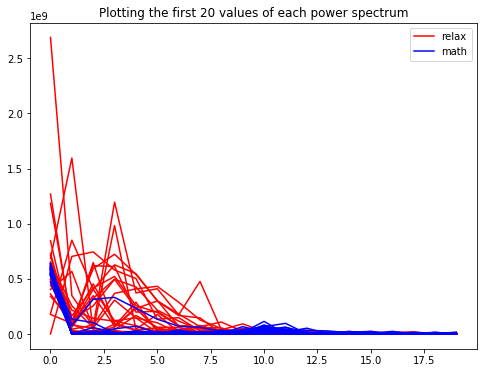

In [105]:
# optionally, your code here...
fig = plt.figure(figsize=(8,6))
relax = plt.plot(X[:30].T[:20],'r')
math = plt.plot(X[30:].T[:20],'b')
plt.legend([relax[0],math[0]],["relax","math"])
plt.title("Plotting the first 20 values of each power spectrum")
plt.show()


As shown in the plot, the power spectrum for math and relax tasks are very different. Hence the classifier finds it very easy to discriminate between the two tasks. If we look at the plot, for all math tasks we considered the power is high initially and then suddenly drops at around a frequency of 2 and stays low. whereas, for relax task the power during low frequencies is much higher and keeps staying high for frequency upto 10Hz.

## Training on the data of 20 people

In [278]:
x_20,y_20 = prepare_features(subject_id=[20])

In [285]:
X_train_20, X_validate_20, y_train_20, y_validate_20 = sklearn.cross_validation.train_test_split(
    x_20, y_20, 
    test_size=0.33, 
    random_state=42)

clf2, cvres2 = xgb_cross_validate(X_train_20, y_train_20)

### Testing on the other 10 people

In [286]:
for id in range(21,31):
    x,y = prepare_features(subject_id=id)
    print("Subject no. ",id, "Accuracy",clf2.score(x,y))

Subject no.  21 Accuracy 0.5
Subject no.  22 Accuracy 0.6
Subject no.  23 Accuracy 0.483333333333
Subject no.  24 Accuracy 0.566666666667
Subject no.  25 Accuracy 0.333333333333
Subject no.  26 Accuracy 0.672131147541
Subject no.  27 Accuracy 0.733333333333
Subject no.  28 Accuracy 0.516666666667
Subject no.  29 Accuracy 0.616666666667
Subject no.  30 Accuracy 0.606557377049


# Extra credit

Discover something new, and describe (or show) it below.

In [66]:
# your code, or words, here
# use the dataset to discover something new..


# lets look at the different tasks.
dataset['label'].unique()

array(['unlabeled', 'blinkInstruction', 'blink1', 'blink2', 'blink3',
       'blink4', 'blink5', 'relaxInstruction', 'relax', 'mathInstruction',
       'math1', 'math2', 'math3', 'math4', 'math5', 'math6', 'math7',
       'math8', 'math9', 'math10', 'math11', 'math12', 'musicInstruction',
       'music', 'videoInstruction', 'video-ver1',
       'thinkOfItemsInstruction-ver1', 'thinkOfItems-ver1',
       'colorInstruction1', 'colorInstruction2', 'readyRound1',
       'colorRound1-1', 'colorRound1-2', 'colorRound1-3', 'colorRound1-4',
       'colorRound1-5', 'colorRound1-6', 'readyRound2', 'colorRound2-1',
       'colorRound2-2', 'colorRound2-3', 'colorRound2-4', 'colorRound2-5',
       'colorRound2-6', 'readyRound3', 'colorRound3-1', 'colorRound3-2',
       'colorRound3-3', 'colorRound3-4', 'colorRound3-5', 'colorRound3-6',
       'readyRound4', 'colorRound4-1', 'colorRound4-2', 'colorRound4-3',
       'colorRound4-4', 'colorRound4-5', 'colorRound4-6', 'readyRound5',
       'colorRound5

In [72]:
# looking at the subjects
dataset['id'].unique()

array([12,  2,  5,  8,  4, 14,  9, 15, 13, 10,  6,  3, 11,  1,  7, 24, 25,
       20, 28, 30, 26, 22, 16, 17, 19, 18, 23, 29, 27, 21])

In [76]:
dataset[dataset['id']==12].label.unique()

array(['unlabeled', 'blinkInstruction', 'blink1', 'blink2', 'blink3',
       'blink4', 'blink5', 'relaxInstruction', 'relax', 'mathInstruction',
       'math1', 'math2', 'math3', 'math4', 'math5', 'math6', 'math7',
       'math8', 'math9', 'math10', 'math11', 'math12', 'musicInstruction',
       'music', 'videoInstruction', 'video-ver1',
       'thinkOfItemsInstruction-ver1', 'thinkOfItems-ver1',
       'colorInstruction1', 'colorInstruction2', 'readyRound1',
       'colorRound1-1', 'colorRound1-2', 'colorRound1-3', 'colorRound1-4',
       'colorRound1-5', 'colorRound1-6', 'readyRound2', 'colorRound2-1',
       'colorRound2-2', 'colorRound2-3', 'colorRound2-4', 'colorRound2-5',
       'colorRound2-6', 'readyRound3', 'colorRound3-1', 'colorRound3-2',
       'colorRound3-3', 'colorRound3-4', 'colorRound3-5', 'colorRound3-6',
       'readyRound4', 'colorRound4-1', 'colorRound4-2', 'colorRound4-3',
       'colorRound4-4', 'colorRound4-5', 'colorRound4-6', 'readyRound5',
       'colorRound5

In [77]:
subject_metadata = pd.read_csv('data/subject-metadata.csv')

In [90]:
# loading all male and female subjects
male_ids = subject_metadata[subject_metadata['Gender']=='m'].ID.tolist()
female_ids = subject_metadata[subject_metadata['Gender']=='f'].ID.tolist()


In [196]:
all_males = dataset[dataset["id"].isin(male_ids)]
all_males_math = all_males[all_males["label"].str.match('math\d')]
all_males_math_raw = all_males_math.raw_values.values

all_females = dataset[dataset["id"].isin(female_ids)]
all_females_math = all_females[all_females["label"].str.match('math\d')]
all_females_math_raw = all_females_math.raw_values.values

In [197]:
# ps = to_power_spectrum(all_males_math_raw[1000])
all_males_math_power_spectrum = [to_power_spectrum(m) for m in all_males_math_raw]
all_females_math_power_spectrum = [to_power_spectrum(m) for m in all_females_math_raw]


In [198]:
def to_power_spectrum_proper(raw_readings,sampling_rate=512):
    fftd = np.fft.fft(raw_readings)
    ps = np.abs(fftd)**2
    half_len = len(ps)//2
    ps = ps[:half_len]
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size, d=1/sampling_rate)
    freqs = freqs[:half_len]
    return freqs,ps

def bandpass (power_spec , low_cutoff,high_cutoff):
    low_cutoff = ceil(low_cutoff)
    high_cutoff = floor(high_cutoff)
    return power_spec[0][low_cutoff:high_cutoff],power_spec[1][low_cutoff:high_cutoff]


In [199]:
all_males_ps = [to_power_spectrum_proper(m) for m in all_males_math_raw]
all_females_ps = [to_power_spectrum_proper(m) for m in all_females_math_raw]

In [200]:
#EEG we are interested in range 0,50
all_males_eeg = np.array([bandpass(m,0,50) for m in all_males_ps])
#EMG we are interested in range 50,150
all_males_emg = np.array([bandpass(m,50,150) for m in all_males_ps])

#EEG we are interested in range 0,50
all_females_eeg = np.array([bandpass(m,0,50) for m in all_females_ps])
#EMG we are interested in range 50,150
all_females_emg = np.array([bandpass(m,50,150) for m in all_females_ps])

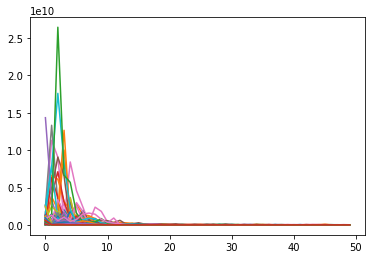

In [193]:
plt.plot(all_males_eeg[:,0].T,all_males_eeg[:,1].T)
plt.show()

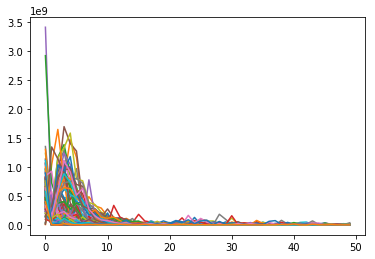

In [202]:
plt.plot(all_females_eeg[:,0].T,all_females_eeg[:,1].T)
plt.show()

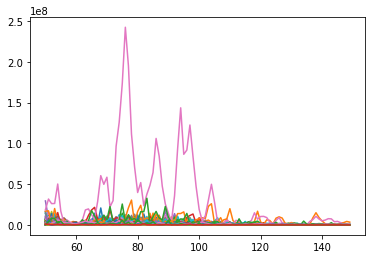

In [194]:
plt.plot(all_males_emg[:,0].T,all_males_emg[:,1].T)
plt.show()

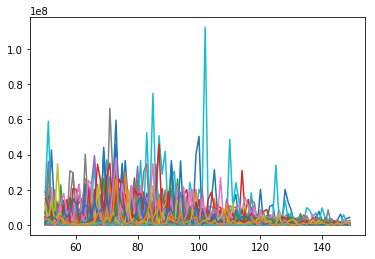

In [203]:
plt.plot(all_females_emg[:,0].T,all_females_emg[:,1].T)
plt.show()

### Analysis

While doing math intensive tasks, females have strong EMG signals which indicates females tend to blink more often than males. The EEG looks about the same though.